In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

pos     = ca.MX.sym('pos', 3)
q       = ca.MX.sym('q', 4)
vel     = ca.MX.sym('vel', 3)
w       = ca.MX.sym('w', 3)
u       = ca.MX.sym('u', 4)
aero_drag = 0.8
m = 1.0
payload_mass = 0.01
drag =1

l = 0.5  #arm length
k = 0.01  # moment constant

# Moments of inertia
J1, J2, J3 = 0.03, 0.03, 0.06

# Create a CasADi diagonal matrix for J
J = ca.diag([J1, J2, J3])

# Define the skew-symmetric matrix function
skew_symmetric_matrix = ca.vertcat(
    ca.horzcat(0, -w[2], w[1], w[0]),
    ca.horzcat(w[2], 0, -w[0], w[1]),
    ca.horzcat(-w[1], w[0], 0, -w[2]),
    ca.horzcat(-w[0], -w[1], w[2], 0)
)

# Create a CasADi Function object for the 4x4 skew-symmetric matrix
skew_symmetric_func_4x4 = ca.Function('skew_symmetric_func_4x4', [w], [skew_symmetric_matrix])

pos_dot = vel

qw = q[0]
qx = q[1]
qy = q[2]
qz = q[3]

# Define the elements of the rotation matrix
r11 = 1 - 2*qy**2 - 2*qz**2
r12 = 2*qx*qy - 2*qz*qw
r13 = 2*qx*qz + 2*qy*qw

r21 = 2*qx*qy + 2*qz*qw
r22 = 1 - 2*qx**2 - 2*qz**2
r23 = 2*qy*qz - 2*qx*qw

r31 = 2*qx*qz - 2*qy*qw
r32 = 2*qy*qz + 2*qx*qw
r33 = 1 - 2*qx**2 - 2*qy**2

# Create a CasADi MX matrix for the rotation matrix
rot_matrix = ca.vertcat(
    ca.horzcat(r11, r12, r13),
    ca.horzcat(r21, r22, r23),
    ca.horzcat(r31, r32, r33)
)

a_thrust  = ca.vertcat(0, 0, ca.sum1(u)) / m
if(drag == 1):
    v_b = ca.mtimes(rot_matrix.T, vel)
    a_drag = -aero_drag * v_b**2 * ca.sign(v_b)/m
    rotor_drag_xy = 0.3
    rotor_drag_z = 0.0
    rotor_drag = ca.vertcat([rotor_drag_xy, rotor_drag_xy, rotor_drag_z])
    a_drag += -rotor_drag * v_b/m

    a_drag_world = ca.mtimes(rot_matrix,a_drag)
else:
    a_drag_world = ca.vertcat(0, 0, 0)

gravity   = ca.vertcat(0, 0, 9.81)
a_payload = -payload_mass * gravity/m


vel_dot = -gravity + ca.mtimes(rot_matrix,a_thrust) + a_payload + a_drag_world
# Attitude dynamics
q_dot = 0.5 * ca.mtimes(skew_symmetric_func_4x4(w), q)

n = ca.vertcat( (l*(u[0] - u[1] - u[2] + u[3])/2**0.5), (l*(-u[0] - u[1] + u[2] + u[3])/2**0.5) , (k*(u[0] - u[1] + u[2] - u[3])))

w_dot = ca.vertcat(
        1 / J1 * (n[0] + (J2 - J3) * w[1] * w[2]),
        1 / J2 * (n[1] + (J3 - J1) * w[2] * w[0]),
        1 / J3 * (n[2] + (J1 - J2) * w[0] * w[1])
    )
w_dot

MX(vertcat((33.3333*(((0.5*(((u[0]-u[1])-u[2])+u[3]))/1.41421)+((-0.03*w[1])*w[2]))), (33.3333*(((0.5*((((-u[0])-u[1])+u[2])+u[3]))/1.41421)+((0.03*w[2])*w[0]))), (16.6667*(0.01*(((u[0]-u[1])+u[2])-u[3])))))

In [2]:
state = ca.vertcat(pos, q, vel, w)
state_dot = ca.vertcat(pos_dot, q_dot, vel_dot, w_dot) # derivative of state vector

dynamics_func = ca.Function('dynamics_func', [state, u], [state_dot]) # in casADI we create funs like this 3rd arg is output


initial_state = ca.vertcat([0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])


In [3]:
T = 5
N = 20
# creating integrator, runge-kutta 4th order 
intg_options = {}
intg_options['tf'] = T/N
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 10

ode = {}
ode['x'] = state
ode['u'] = u
ode['ode'] = dynamics_func(state, u)

intg = ca.integrator('intg', 'rk', ode, intg_options) # rk =runge-kutta

ini_u = ca.vertcat(5,1,1,1)

CasADi - 2024-02-20 22:10:45 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


In [4]:
res = intg(x0 = state, u= u)
next_state = res['xf'] 

# print(state.type)
F = ca.Function('F',[state,u],[next_state],['state','u'],['next_state'])
sim = F.mapaccum(N)
u_values = np.random.uniform(0, 5, (N, 4))
print(u_values.shape)
u_values = np.zeros((N,4))

print(u_values.shape)

(20, 4)
(20, 4)


(13, 21)


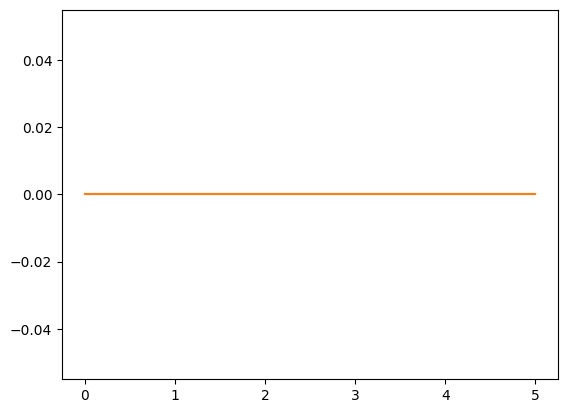

In [11]:
x0 = initial_state
res = sim(x0,u_values.T)

plt.figure
tgrid = ca.linspace(0,T,N+1)
i = 10
full = ca.horzcat(x0,res)
print(full.shape)
plt.plot(tgrid,full[i,:].T)
tgrid = ca.linspace(0,T,N)
plt.plot(tgrid,res[i,:].T)
# plt.plot(tgrid,res[1,:].T)
# plt.plot(tgrid,res[2,:].T)
# plt.plot(res[2,:10])
# print(res[2,:10])

In [14]:
U = ca.MX.sym('U',4,N)
X1 = sim(x0,U)[1,:]
print(X1.shape)
J = ca.jacobian(X1,U)
print(J.shape)
print(X1.shape)

(1, 20)
(20, 80)
(1, 20)


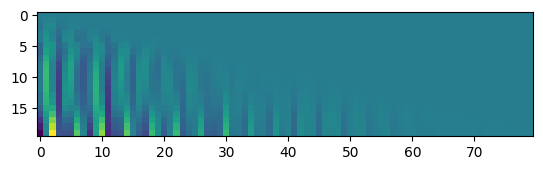

In [15]:
Jf = ca.Function('Jf',[U],[J])
u_values = np.random.uniform(0, 5, (N, 4))
plt.imshow(Jf(u_values.T).full())

In [21]:
Jf(u_values.T)

DM(
[[-0.00662904, 0.0094007, 0.00720241, ..., 00, 00, 00], 
 [-0.161106, 0.123856, 0.167463, ..., 00, 00, 00], 
 [-0.382233, 0.338962, 0.382346, ..., 00, 00, 00], 
 ...,
 [-2.56172, 0.775916, 3.63053, ..., 00, 00, 00], 
 [-3.33013, 0.4842, 4.55911, ..., 00, 00, 00], 
 [-4.10765, 0.182817, 5.54563, ..., 0.0150092, 0.0126825, 0.0119854]])

In [352]:

opti = ca.Opti()
x = opti.variable(13,N+1) # 13 control inputs, N+1 states
u = opti.variable(4,N)
p = opti.parameter(13,1)


cost = ca.sumsqr(x)+ca.sumsqr(u) #least control input
opti.minimize(cost) # for collision avoidance need another maximizer should be added to cost function

# equality constraints - adding state transition constriants, here F is state transition constarint
for k in range(N):

    opti.subject_to(x[:,k+1] == F(x[:,k],u[:,k]))

opti.subject_to(x[:, 20] == p) # 20th step 
opti.subject_to(x[:, 0] == p) # 0 is initial step, can put diff value to p 

#inequality constraints
opti.subject_to(opti.bounded(0, u, 5)) # motor can produce only +ve thrust so bounded between 0,5
 
opti.set_value(p, initial_state) # p is parameter, given to optimizer

opti.solver('ipopt')  # Choose your solver # used for nonlinear progr
opti.solve()

# Retrieve the optimized variables
x_opt = opti.value(x)
u_opt = opti.value(u)




This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3286
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:     2173

Total number of variables............................:      353
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      286
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [33]:

opti = ca.Opti()
x = opti.variable(13,N+1) # 13 control inputs, N+1 states
u = opti.variable(4,N)
pi = opti.parameter(13,1)
pf = opti.parameter(13,1)

cost = ca.sumsqr(x)+ca.sumsqr(u) #least control input
opti.minimize(cost) # for collision avoidance need another maximizer should be added to cost function

# equality constraints - adding state transition constriants, here F is state transition constarint
for k in range(N):

    opti.subject_to(x[:,k+1] == F(x[:,k],u[:,k]))

final_state = ca.vertcat([1.0, 2.0, 3.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])
opti.subject_to(x[:, 17] == pf) # 20th step 
opti.subject_to(x[:, 0] == pi) # 0 is initial step, can put diff value to p 

#inequality constraints
opti.subject_to(opti.bounded(0, u, 5)) # motor can produce only +ve thrust so bounded between 0,5
 
opti.set_value(pi, initial_state) # p is parameter, given to optimizer
opti.set_value(pf, final_state)

opti.solver('ipopt')  # Choose your solver # used for nonlinear progr
opti.solve()

# Retrieve the optimized variables
x_opt = opti.value(x)
u_opt = opti.value(u)




This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3286
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:     2173

Total number of variables............................:      353
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      286
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

CasADi - 2024-02-20 14:52:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 78, col 0).") [.../casadi/core/oracle_function.cpp:377]


  24  6.4282159e+02 2.38e-10 1.45e+08  -5.7 9.14e-05  10.9 1.00e+00 1.00e+00h  1
  25  6.4282159e+02 2.36e-10 1.45e+08  -5.7 1.99e-07  14.9 1.00e+00 3.05e-05h 16
  26r 6.4282159e+02 2.36e-10 6.36e+01  -5.7 0.00e+00  14.4 0.00e+00 4.77e-07R 22
  27r 6.4282169e+02 9.20e-07 3.66e-06  -5.7 3.73e-03    -  1.00e+00 1.00e+00f  1
  28r 6.4282160e+02 9.01e-07 3.65e-06  -8.6 3.68e-03    -  1.00e+00 1.00e+00h  1
  29r 6.4282159e+02 6.54e-10 6.19e-09  -8.6 8.66e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.4273763e+02 1.44e-03 2.98e+00  -5.7 1.38e-01    -  1.00e+00 1.00e+00f  1
  31  6.4271743e+02 2.02e-03 5.73e+02  -5.7 2.78e-01    -  1.00e+00 5.00e-01f  2
  32  6.4265101e+02 2.92e-06 1.46e+14  -5.7 7.60e-03  14.0 1.00e+00 1.00e+00h  1
  33  6.4265126e+02 2.61e-08 4.13e+13  -5.7 6.40e-04  13.5 1.00e+00 1.00e+00h  1
  34  6.4265127e+02 6.40e-11 5.21e+12  -5.7 4.23e-05  13.0 1.00e+00 1.00e+00h  1
  35  6.4265127e+02 6.37e-11

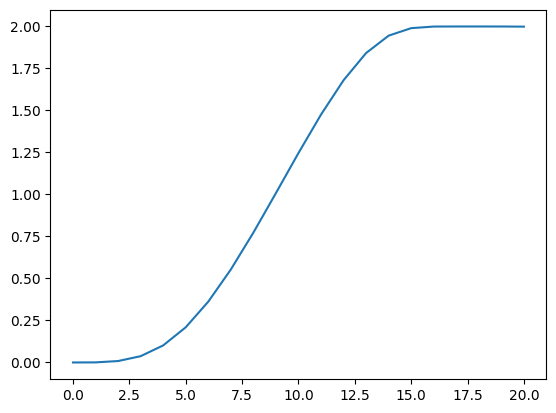

In [34]:
x_opt = opti.value(x)
u_opt = opti.value(u)
pi_opt = opti.value(pi)
pf_opt = opti.value(pf)

plt.plot(x_opt[1,:])

[2.51625256 2.55069512 2.53400884 2.51740809 2.50643144 2.50113528
 2.49852353 2.49673907 2.49529414 2.49415253 2.49331835 2.49268008
 2.49184951 2.49004943 2.48597894 2.47758614 2.46386852 2.44296695
 2.40320915 2.37990188]


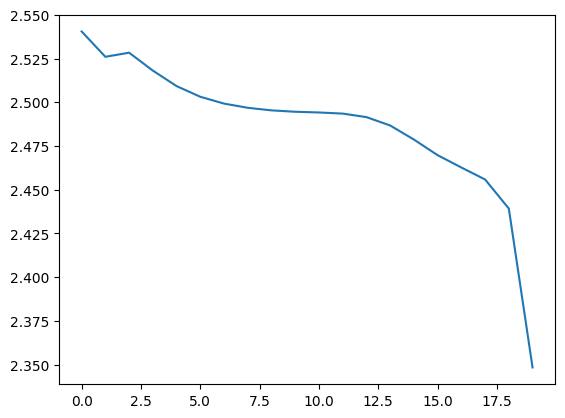

In [350]:
plt.plot(u_opt[1,:])
print(u_opt[2,:])